In [2]:
!pip install -r requirements.txt

  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufile_cu12-1.11.1.6-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cura

# Download data from Kaggle manually: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset into data/

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset",path="data")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

## Dependencies

In [ ]:
import os
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import trainset_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing._label as _l
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
import torch
from torch.utils.data import DataLoader, Subset
from torch.serialization import add_safe_globals
# Own modules
from src.data_preprocessor import TextPreprocessor, FakeNewsDataset, collate_fn
from src.han_model import HierarchicalAttentionNetwork
from src.model_trainer import ModelTrainer

## Control Variables

In [3]:
# CONTROL CONSTANTS
ENABLE_TRAINING = True
ENABLE_VALIDATION = True
ENABLE_KFOLD_CV = True
ENABLE_BOOTSTRAP_VALIDATION = True
ENABLE_LEARNING_CURVE = False
SAVE_PLOTS = True
VERBOSE_OUTPUT = True

# CONFIGURATION CONSTANTS
DATA_PATH = "data/"
MODEL_SAVE_PATH = "best_han_model.pth"
VOCAB_PATH = "vocabulary.pkl"
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 16
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.1
K_FOLDS = 5
N_BOOTSTRAP = 100
MAX_SENTENCES = 20
MAX_WORDS_PER_SENTENCE = 50
MAX_VOCAB_SIZE = 50000
MIN_WORD_FREQ = 2
PATIENCE = 3
RANDOM_STATE = 42

## Utils

In [ ]:
# if you don't want to train the model from scratch we have run the notebook and saved it to google drive: https://drive.google.com/file/d/16HCaqszdyeXFOCiWHkKZ0ljFw0yzu4Hg/view?usp=sharing
# so you can just use load_trained_model after you download the model and put it in this folder :)

def load_trained_model(model_path="best_han_model.pth", device=None):
    """
    Load a trained HAN model from checkpoint.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load checkpoint
    add_safe_globals([_l.LabelEncoder])
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    # Create model with saved configuration
    model = HierarchicalAttentionNetwork(**checkpoint["model_config"])

    # Load trained weights
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    print(f"Model loaded from {model_path}")
    print(f"Best validation accuracy: {checkpoint.get('highest_validation_accuracy', 'N/A')}")

    return model, checkpoint["model_config"], checkpoint

In [ ]:
def get_model_predictions(model, data_loader, label_encoder, device=None):
    """
    Get predictions for the whole dataset.
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()

    all_predictions = []
    all_true_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Getting predictions"):
            documents, word_lengths, sentence_lengths, labels = batch

            # Move to device
            documents = documents.to(device)
            word_lengths = word_lengths.to(device)
            sentence_lengths = sentence_lengths.to(device)

            # Forward pass
            logits, _, _ = model(documents, word_lengths, sentence_lengths)

            # Get predictions and probabilities
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Convert to label names
    predicted_labels = label_encoder.inverse_transform(all_predictions)
    true_labels = label_encoder.inverse_transform(all_true_labels)

    return {
        "predictions": predicted_labels,
        "true_labels": true_labels,
        "probabilities": all_probabilities,
        "prediction_indices": all_predictions,
        "true_label_indices": all_true_labels,
    }

## Pipeline

In [ ]:
class FakeNewsAnalyzer:
    """Comprehensive fake news detection analysis pipeline."""

    def __init__(self):
        self.preprocessor = None
        self.label_encoder = None
        self.trainset_data = None
        self.validationset_data = None
        self.test_data = None
        self.model = None
        self.training_results = None

    #################
    # Generatl utils
    #################

    def load_and_prepare_data(self):
        print("Loading data...")
        fake = pd.read_csv(os.path.join(DATA_PATH, "Fake.csv"))
        true = pd.read_csv(os.path.join(DATA_PATH, "True.csv"))
        fake["label"] = "fake"
        true["label"] = "true"
        data = pd.concat([fake, true], ignore_index=True)
        trainset_data, temp_data = trainset_test_split(
            data, test_size=TEST_SIZE, stratify=data["label"], random_state=RANDOM_STATE
        )
        validationset_data, test_data = trainset_test_split(
            temp_data,
            test_size=0.5,
            stratify=temp_data["label"],
            random_state=RANDOM_STATE,
        )
        self.trainset_data, self.validationset_data, self.test_data = trainset_data, validationset_data, test_data
        if VERBOSE_OUTPUT:
            self._print_data_info()
        return trainset_data, validationset_data, test_data

    def _print_data_info(self):
        """Print dataset information."""
        print(f"Dataset splits:")
        print(f"Train: {len(self.trainset_data)} samples")
        print(f"Validation: {len(self.validationset_data)} samples")
        print(f"Test: {len(self.test_data)} samples")
        print("\nLabel distribution:")
        for name, data in [
            ("Train", self.trainset_data),
            ("Validation", self.validationset_data),
            ("Test", self.test_data),
        ]:
            print(f"{name} set:")
            print(data["label"].value_counts())

    def prepare_preprocessing(self):
        print("Building vocabulary...")
        self.preprocessor = TextPreprocessor(
            maximum_vocabulary_size=MAX_VOCAB_SIZE, minimum_word_frequency=MIN_WORD_FREQ
        )
        self.preprocessor.build_vocabulary(self.trainset_data["text"].tolist())
        self.preprocessor.save_vocabulary(VOCAB_PATH)
        print("Encoding labels...")
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.trainset_data["label"])
        if VERBOSE_OUTPUT:
            print(f"Vocabulary size: {self.preprocessor.vocabulary_size}")
            print(
                f"Label mapping: {dict(zip(self.label_encoder.classes_, self.label_encoder.transform(self.label_encoder.classes_)))}"
            )

    def create_datasets_and_loaders(self, data_splits=None):
        print("Creating datasets and data loaders...")
        if data_splits is None:
            data_splits = (self.trainset_data, self.validationset_data, self.test_data)
        trainset_data, validationset_data, test_data = data_splits
        # Create dataset objects
        datasets = []
        for data in [trainset_data, validationset_data, test_data]:
            texts = data["text"].tolist()
            labels = self.label_encoder.transform(data["label"])
            dataset = FakeNewsDataset(
                texts, labels, self.preprocessor, MAX_SENTENCES, MAX_WORDS_PER_SENTENCE
            )
            datasets.append(dataset)
        # Create data loaders
        trainset_loader = DataLoader(
            datasets[0],
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=2,
        )
        validationset_loader = DataLoader(
            datasets[1],
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
        )
        test_loader = DataLoader(
            datasets[2],
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
        )
        return datasets, (trainset_loader, validationset_loader, test_loader)

    def trainset_model(self, trainset_loader, validationset_loader):
        print("Training HAN model...")
        trainer = ModelTrainer(
            vocabulary_size=self.preprocessor.vocabulary_size,
            number_of_classes=len(self.label_encoder.classes_),
            label_encoder=self.label_encoder,
        )
        self.training_results = trainer.train(
            trainset_loader=trainset_loader,
            validationset_loader=validationset_loader,
            number_of_epochs=NUM_EPOCHS,
            learning_rate=LEARNING_RATE,
            save_path=MODEL_SAVE_PATH,
            patience=PATIENCE,
        )
        # Save additional metadata
        self._save_model_metadata(trainer)
        self.model = trainer.model
        return trainer

    def _save_model_metadata(self, trainer):
        additional_data = {
            "label_encoder": self.label_encoder,
            "vocabulary_size": self.preprocessor.vocabulary_size,
            "number_of_classes": len(self.label_encoder.classes_),
            "training_results": self.training_results,
        }
        checkpoint = torch.load(MODEL_SAVE_PATH, weights_only=False)
        checkpoint.update(additional_data)
        torch.save(checkpoint, MODEL_SAVE_PATH)

    def evaluate_model_comprehensive(self, model, validationset_loader, test_loader):
        if VERBOSE_OUTPUT:
            print("=" * 60)
            print("COMPREHENSIVE VALIDATION PERFORMANCE REPORT")
            print("=" * 60)
        validationset_results = get_model_predictions(model, validationset_loader, self.label_encoder)
        test_results = get_model_predictions(model, test_loader, self.label_encoder)
        report = self._generate_performance_report(validationset_results, test_results)
        if SAVE_PLOTS:
            self._generate_evaluation_plots(validationset_results, test_results)
        return report

    def perform_bootstrap_validation(self, test_loader):
        print("Performing bootstrap validation...")
        if VERBOSE_OUTPUT:
            print("=" * 60)
            print(f"BOOTSTRAP VALIDATION (n={N_BOOTSTRAP})")
            print("=" * 60)
        # Get test predictions
        test_results = get_model_predictions(
            self.model, test_loader, self.label_encoder
        )
        true_labels = np.array(test_results["true_labels"])
        predictions = np.array(test_results["predictions"])
        probabilities = np.array(test_results["probabilities"])
        bootstrap_metrics = defaultdict(list)
        n_samples = len(true_labels)
        for i in range(N_BOOTSTRAP):
            if VERBOSE_OUTPUT and (i + 1) % 20 == 0:
                print(f" Bootstrap iteration {i + 1}/{N_BOOTSTRAP}")
            # Sample with replacement
            bootstrap_idx = np.random.choice(n_samples, n_samples, replace=True)
            boot_metrics = self._calculate_bootstrap_metrics(
                true_labels[bootstrap_idx],
                predictions[bootstrap_idx],
                probabilities[bootstrap_idx],
            )
            for metric, value in boot_metrics.items():
                bootstrap_metrics[metric].append(value)
        bootstrap_stats = self._calculate_bootstrap_statistics(bootstrap_metrics)
        if SAVE_PLOTS:
            self._plot_bootstrap_distributions(bootstrap_stats)
        return bootstrap_stats

    def _calculate_bootstrap_metrics(self, true_labels, predictions, probabilities):
        """Calculate metrics for bootstrap sample."""
        probabilities = np.array(probabilities)
        metrics = self._calculate_metrics(
            {"true_labels": true_labels, "predictions": predictions}
        )
        # Add AUC for binary classification
        if len(self.label_encoder.classes_) == 2:
            try:
                auc = roc_auc_score(true_labels, probabilities[:, 1])
                metrics["auc"] = auc
            except:
                pass  # Skip if all one class
        return metrics

    def _calculate_bootstrap_statistics(self, bootstrap_metrics):
        """Calculate bootstrap confidence intervals."""
        bootstrap_stats = {}
        if VERBOSE_OUTPUT:
            print("\nBOOTSTRAP CONFIDENCE INTERVALS (95%)")
            print("=" * 40)
        for metric, values in bootstrap_metrics.items():
            mean_val = np.mean(values)
            ci_lower, ci_upper = np.percentile(values, [2.5, 97.5])
            bootstrap_stats[metric] = {
                "mean": mean_val,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper,
                "values": values,
            }
            if VERBOSE_OUTPUT:
                print(
                    f"{metric.capitalize()}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]"
                )
        return bootstrap_stats

    def perform_kfold_validation(self):
        print("Initializing k-fold cross validation...")
        if VERBOSE_OUTPUT:
            print("=" * 60)
            print(f"K-FOLD CROSS VALIDATION (k={K_FOLDS})")
            print("=" * 60)
        # Combine all data for k-fold
        full_data = pd.concat([self.trainset_data, self.validationset_data], ignore_index=True)
        texts = full_data["text"].tolist()
        labels = self.label_encoder.transform(full_data["label"])
        full_dataset = FakeNewsDataset(
            texts, labels, self.preprocessor, MAX_SENTENCES, MAX_WORDS_PER_SENTENCE
        )
        # Perform k-fold
        kfold = StratifiedKFold(
            n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE
        )
        fold_results = []
        fold_metrics = defaultdict(list)
        for fold, (trainset_idx, validationset_idx) in enumerate(kfold.split(texts, labels)):
            if VERBOSE_OUTPUT:
                print(f"\nFold {fold + 1}/{K_FOLDS}")
            fold_result = self._trainset_and_evaluate_fold(
                full_dataset, trainset_idx, validationset_idx, fold
            )
            fold_results.append(fold_result)
            # Store metrics for statistics
            for metric in ["accuracy", "precision", "recall", "f1_score"]:
                fold_metrics[metric].append(fold_result[metric])
        cv_stats = self._calculate_cv_statistics(fold_metrics)
        if SAVE_PLOTS:
            self._plot_kfold_results(fold_results, cv_stats)
        return fold_results, cv_stats

    def _trainset_and_evaluate_fold(self, full_dataset, trainset_idx, validationset_idx, fold):
        """Train and evaluate a single fold."""
        # Create fold datasets
        trainset_subset = Subset(full_dataset, trainset_idx)
        validationset_subset = Subset(full_dataset, validationset_idx)
        # Create data loaders
        trainset_loader = DataLoader(
            trainset_subset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=2,
        )
        validationset_loader = DataLoader(
            validationset_subset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
        )
        # Train model
        trainer = ModelTrainer(
            vocabulary_size=self.preprocessor.vocabulary_size,
            number_of_classes=len(self.label_encoder.classes_),
            label_encoder=self.label_encoder,
        )
        fold_epochs = max(5, NUM_EPOCHS // 2)
        trainer.train(
            trainset_loader=trainset_loader,
            validationset_loader=validationset_loader,
            number_of_epochs=fold_epochs,
            learning_rate=LEARNING_RATE,
            save_path=None,
            patience=2,
        )
        # Evaluate fold
        validationset_results = get_model_predictions(
            trainer.model, validationset_loader, self.label_encoder
        )
        metrics = self._calculate_metrics(validationset_results)
        fold_result = {"fold": fold + 1, **metrics}
        if VERBOSE_OUTPUT:
            print(
                f"Fold {fold + 1} Results: Acc={metrics['accuracy']:.4f}, F1={metrics['f1_score']:.4f}"
            )
        return fold_result

    def _calculate_cv_statistics(self, fold_metrics):
        print("Computing cross-validation statistics...")
        cv_stats = {}
        if VERBOSE_OUTPUT:
            print("\n" + "=" * 40)
            print("CROSS-VALIDATION SUMMARY")
            print("=" * 40)
        for metric in ["accuracy", "precision", "recall", "f1_score"]:
            values = fold_metrics[metric]
            mean_val, std_val = np.mean(values), np.std(values)
            cv_stats[metric] = {
                "mean": mean_val,
                "std": std_val,
                "min": min(values),
                "max": max(values),
                "values": values,
            }
            if VERBOSE_OUTPUT:
                print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")
        return cv_stats


    ######################
    # Evaluation pipeline
    ######################
    def _generate_performance_report(self, validationset_results, test_results):
        print("Computing performance metrics...")
        report = {}
        # Basic metrics
        for name, results in [("Validation", validationset_results), ("Test", test_results)]:
            metrics = self._calculate_metrics(results)
            report[f"{name.lower()}_metrics"] = metrics
            if VERBOSE_OUTPUT:
                print(f"\n{name} Set Performance:")
                for metric, value in metrics.items():
                    print(f" {metric.capitalize()}: {value:.4f}")
        # ROC AUC for binary classification
        if len(self.label_encoder.classes_) == 2:
            validationset_probs = np.array(validationset_results["probabilities"])
            test_probs = np.array(test_results["probabilities"])
            try:
                validationset_auc = roc_auc_score(validationset_results["true_labels"], validationset_probs[:, 1])
                test_auc = roc_auc_score(test_results["true_labels"], test_probs[:, 1])
            except ValueError:
                validationset_auc = float("nan")
                test_auc = float("nan")
            report.update({"validationset_auc": validationset_auc, "test_auc": test_auc})
            if VERBOSE_OUTPUT:
                print(f"\nROC AUC - Validation: {validationset_auc:.4f}, Test: {test_auc:.4f}")
        # Overfitting analysis
        overfitting_gap = abs(
            report["validation_metrics"]["accuracy"]
            - report["test_metrics"]["accuracy"]
        )
        report["overfitting_gap"] = overfitting_gap
        if VERBOSE_OUTPUT:
            self._analyze_overfitting(overfitting_gap)
        return report

    def _calculate_metrics(self, results):
        print("Computing standard classification metrics...")
        accuracy = accuracy_score(results["true_labels"], results["predictions"])
        precision, recall, f1, _ = precision_recall_fscore_support(
            results["true_labels"], results["predictions"], average="weighted"
        )
        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

    def _analyze_overfitting(self, gap):
        print("Analyzing overfitting...")
        if gap > 0.05:
            print(
                "⚠️ WARNING: Significant performance gap detected. Model may be overfitting."
            )
        elif gap > 0.02:
            print(
                "⚠️ CAUTION: Moderate performance gap detected. Monitor for overfitting."
            )
        else:
            print(
                "✅ Good generalization: Small performance gap between validation and test."
            )

    def _generate_evaluation_plots(self, validationset_results, test_results):
        print("Generating evaluation plots...")
        if len(self.label_encoder.classes_) == 2:
            self._plot_roc_curves(validationset_results, test_results)
            self._plot_precision_recall_curves(validationset_results, test_results)
        self._plot_confusion_matrices(validationset_results, test_results)
        if self.training_results and SAVE_PLOTS:
            self._plot_training_history()

    #############
    # Plot utils
    #############
    def _plot_roc_curves(self, validationset_results, test_results):
        """Plot ROC curves for both validation and test sets."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        for ax, results, title in [
            (ax1, validationset_results, "Validation"),
            (ax2, test_results, "Test"),
        ]:
            # 1) Convert probability lists to a NumPy array so we can slice
            probs = np.array(results["probabilities"])  # shape (N, 2)
            scores = probs[:, 1]  # “score” for class 1
            # 2) Convert y_true into a binary 0/1 array
            y_true_raw = np.array(results["true_labels"])
            if y_true_raw.dtype.kind in ("U", "S", "O"):  # string or object dtype
                # Assume pos_label is "true"
                y_true = (y_true_raw == "true").astype(int)
            else:
                # Already numeric (0/1)
                y_true = y_true_raw.astype(int)
            # 3) Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true, scores)
            auc = roc_auc_score(y_true, scores)
            # 4) Plot
            ax.plot(fpr, tpr, label=f"{title} (AUC = {auc:.3f})")
            ax.plot([0, 1], [0, 1], "k--", label="Random")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title(f"{title} ROC Curve")
            ax.legend()
            ax.grid(True)
        plt.tight_layout()
        plt.savefig("./plots/roc_curves.png", dpi=300, bbox_inches="tight")
        plt.show()

    def _plot_precision_recall_curves(self, validationset_results, test_results):
        """Plot Precision–Recall curves for validation and test sets."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        for ax, results, title in [
            (ax1, validationset_results, "Validation"),
            (ax2, test_results, "Test"),
        ]:
            # 1) Convert probability lists to a NumPy array so we can slice
            probs = np.array(results["probabilities"])  # shape (N, 2)
            scores = probs[:, 1]  # “score” for class-1
            # 2) Convert y_true into a binary 0/1 array
            y_true_raw = np.array(results["true_labels"])
            if y_true_raw.dtype.kind in ("U", "S", "O"):  # string or object dtype
                # Assume positive class is "true"
                y_true = (y_true_raw == "true").astype(int)
            else:
                # Already numeric (0/1)
                y_true = y_true_raw.astype(int)
            # 3) Compute Precision–Recall curve and Average Precision
            precision, recall, _ = precision_recall_curve(y_true, scores)
            ap = average_precision_score(y_true, scores)
            # 4) Plot
            ax.plot(recall, precision, label=f"{title} (AP = {ap:.3f})")
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_title(f"{title} Precision–Recall Curve")
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.savefig("./plots/precision_recall_curves.png", dpi=300, bbox_inches="tight")
        plt.show()

    def _plot_confusion_matrices(self, validationset_results, test_results):
        """Plot confusion matrices for validation and test sets."""
        # Ensure label_encoder is set on self
        if not hasattr(self, "label_encoder"):
            raise AttributeError(
                "self.label_encoder must be defined before calling _plot_confusion_matrices"
            )
        # Class names come from the encoder (e.g. ["fake", "true"])
        class_names = list(self.label_encoder.classes_)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        for ax, results, title, cmap in [
            (ax1, validationset_results, "Validation", "Blues"),
            (ax2, test_results, "Test", "Oranges"),
        ]:
            y_true = np.array(results["true_labels"])
            y_pred = np.array(results["predictions"])
            # Decide whether labels are numeric or string:
            if y_true.dtype.kind in ("U", "S", "O") or y_pred.dtype.kind in (
                "U",
                "S",
                "O",
            ):
                # String case: force labels to ["fake","true"]
                labels_to_use = class_names
            else:
                # Numeric case: force labels to [0,1]
                labels_to_use = [0, 1]
            # Now compute a 2×2 confusion matrix with the chosen labels list
            cm = confusion_matrix(y_true, y_pred, labels=labels_to_use)
            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap=cmap,
                xticklabels=labels_to_use,
                yticklabels=labels_to_use,
                ax=ax,
            )
            ax.set_title(f"{title} Confusion Matrix")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        plt.tight_layout()
        plt.savefig("./plots/confusion_matrices.png", dpi=300, bbox_inches="tight")
        plt.show()

    def _plot_training_history(self):
        """Plot training history."""
        if "trainset_losses" not in self.training_results:
            return
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        # Plot losses
        ax1.plot(
            self.training_results["trainset_losses"], label="Training Loss", marker="o"
        )
        ax1.plot(
            self.training_results["validationset_losses"], label="Validation Loss", marker="s"
        )
        ax1.set_title("Training and Validation Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)
        # Plot accuracies
        if (
            "trainset_accuracies" in self.training_results
            and "validationset_accuracyuracies" in self.training_results
        ):
            ax2.plot(
                self.training_results["trainset_accuracies"],
                label="Training Accuracy",
                marker="o",
            )
            ax2.plot(
                self.training_results["validationset_accuracyuracies"],
                label="Validation Accuracy",
                marker="s",
            )
            ax2.set_title("Training and Validation Accuracy")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("Accuracy")
            ax2.legend()
            ax2.grid(True)
        plt.tight_layout()
        plt.savefig("./plots/training_history.png", dpi=300, bbox_inches="tight")
        plt.show()

    def _plot_kfold_results(self, fold_results, cv_stats):
        """Plot k-fold results."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        metrics = ["accuracy", "precision", "recall", "f1_score"]
        titles = ["Accuracy", "Precision", "Recall", "F1-Score"]
        axes = [ax1, ax2, ax3, ax4]
        for metric, title, ax in zip(metrics, titles, axes):
            values = cv_stats[metric]["values"]
            folds = range(1, len(values) + 1)
            mean_val = cv_stats[metric]["mean"]
            std_val = cv_stats[metric]["std"]
            ax.plot(folds, values, "bo-", label="Fold Results")
            ax.axhline(
                y=mean_val, color="r", linestyle="--", label=f"Mean = {mean_val:.3f}"
            )
            ax.fill_between(
                folds,
                [mean_val - std_val] * len(folds),
                [mean_val + std_val] * len(folds),
                alpha=0.2,
                color="red",
                label=f"±1 Std",
            )
            ax.set_xlabel("Fold")
            ax.set_ylabel(title)
            ax.set_title(f"K-Fold {title}")
            ax.legend()
            ax.grid(True)
            ax.set_xticks(folds)
        plt.tight_layout()
        plt.savefig("./plots/kfold_results.png", dpi=300, bbox_inches="tight")
        plt.show()

    def _plot_bootstrap_distributions(self, bootstrap_stats):
        """Plot bootstrap distributions."""
        n_metrics = min(len(bootstrap_stats), 4)
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        for i, (metric, stats) in enumerate(list(bootstrap_stats.items())[:4]):
            values = stats["values"]
            ax = axes[i]
            ax.hist(values, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
            mean_val = stats["mean"]
            ci_lower, ci_upper = stats["ci_lower"], stats["ci_upper"]
            ax.axvline(
                mean_val,
                color="red",
                linestyle="--",
                linewidth=2,
                label=f"Mean = {mean_val:.3f}",
            )
            ax.axvline(ci_lower, color="orange", linestyle=":", linewidth=2)
            ax.axvline(ci_upper, color="orange", linestyle=":", linewidth=2)
            ax.fill_betweenx(
                [0, ax.get_ylim()[1]],
                ci_lower,
                ci_upper,
                alpha=0.3,
                color="orange",
                label=f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]",
            )
            ax.set_xlabel(metric.capitalize())
            ax.set_ylabel("Frequency")
            ax.set_title(f"Bootstrap Distribution: {metric.capitalize()}")
            ax.legend()
            ax.grid(True, alpha=0.3)
        # Hide unused subplots
        for i in range(n_metrics, 4):
            axes[i].set_visible(False)
        plt.tight_layout()
        plt.savefig("./plots/bootstrap_distributions.png", dpi=300, bbox_inches="tight")
        plt.show()

    ##################
    # Actual pipeline
    ##################

    def run_complete_analysis(self):
        print("Starting Fake News Detection Analysis Pipeline")
        validation_report = None
        kfold_results = cv_stats = None
        bootstrap_stats = None
        # 1. Data preparation
        self.load_and_prepare_data()
        self.prepare_preprocessing()
        # 2. Data loaders
        datasets, (trainset_loader, validationset_loader, test_loader) = (self.create_datasets_and_loaders())
        # 3. Model training
        if ENABLE_TRAINING:
            trainer = self.trainset_model(trainset_loader, validationset_loader)
        else:
            # Load existing model and vocabulary
            self.model, _, checkpoint = load_trained_model(MODEL_SAVE_PATH)
            print("Checkpoint keys:", checkpoint.keys())
            self.preprocessor = TextPreprocessor()
            self.preprocessor.load_vocabulary(VOCAB_PATH)
            self.label_encoder = checkpoint["label_encoder"]
        # 4. Comprehensive validation
        if ENABLE_VALIDATION:
            validation_report = self.evaluate_model_comprehensive(
                self.model, validationset_loader, test_loader
            )
        # 5. K-fold cross validations
        if ENABLE_KFOLD_CV:
            kfold_results, cv_stats = self.perform_kfold_validation()
        # 6. Bootstrap validation
        if ENABLE_BOOTSTRAP_VALIDATION:
            bootstrap_stats = self.perform_bootstrap_validation(test_loader)
        return {
            "validation_report": validation_report if ENABLE_VALIDATION else None,
            "kfold_results": (kfold_results, cv_stats) if ENABLE_KFOLD_CV else None,
            "bootstrap_stats": bootstrap_stats if ENABLE_BOOTSTRAP_VALIDATION else None,
        }


Starting Fake News Detection Analysis Pipeline
Loading data...
Dataset splits:
Train: 35918 samples
Validation: 4490 samples
Test: 4490 samples

Label distribution:
Train set:
label
fake    18785
true    17133
Name: count, dtype: int64
Validation set:
label
fake    2348
true    2142
Name: count, dtype: int64
Test set:
label
fake    2348
true    2142
Name: count, dtype: int64
Building vocabulary...
Building vocabulary...


Processing texts: 100%|██████████| 35918/35918 [00:41<00:00, 871.27it/s]


Vocabulary size: 50000
Encoding labels...
Vocabulary size: 50000
Label mapping: {'fake': np.int64(0), 'true': np.int64(1)}
Creating datasets and data loaders...


Convertng text to hierarchical format...: 100%|██████████| 4490/4490 [00:04<00:00, 1031.19it/s]


Training HAN model...
Model created with 10,141,802 parameters
Using device: cuda
Starting training...
Training samples:   35918
Validation samples: 4490


Epoch 1/10: 100%|██████████| 2245/2245 [00:37<00:00, 59.33it/s, Loss=0.0002, Acc=1.0000]



Epoch 1/10:
  Train Loss: 0.0274, Train Acc: 0.9910
  Val   Loss: 0.0042, Val   Acc: 0.9989
  Learning Rate: 0.001000
  ✓ New best model saved! Val Acc: 0.9989



Epoch 2/10: 100%|██████████| 2245/2245 [00:36<00:00, 62.34it/s, Loss=0.0003, Acc=1.0000]



Epoch 2/10:
  Train Loss: 0.0046, Train Acc: 0.9986
  Val   Loss: 0.0046, Val   Acc: 0.9989
  Learning Rate: 0.001000
  No improvement. Patience: 1/3



Epoch 3/10: 100%|██████████| 2245/2245 [00:36<00:00, 61.69it/s, Loss=0.0002, Acc=1.0000]



Epoch 3/10:
  Train Loss: 0.0035, Train Acc: 0.9991
  Val   Loss: 0.0024, Val   Acc: 0.9998
  Learning Rate: 0.000700
  ✓ New best model saved! Val Acc: 0.9998



Epoch 4/10: 100%|██████████| 2245/2245 [00:37<00:00, 60.03it/s, Loss=0.0000, Acc=1.0000]



Epoch 4/10:
  Train Loss: 0.0018, Train Acc: 0.9996
  Val   Loss: 0.0038, Val   Acc: 0.9993
  Learning Rate: 0.000700
  No improvement. Patience: 1/3



Epoch 5/10: 100%|██████████| 2245/2245 [00:37<00:00, 60.50it/s, Loss=0.0000, Acc=1.0000]



Epoch 5/10:
  Train Loss: 0.0015, Train Acc: 0.9997
  Val   Loss: 0.0034, Val   Acc: 0.9996
  Learning Rate: 0.000700
  No improvement. Patience: 2/3



Epoch 6/10: 100%|██████████| 2245/2245 [00:37<00:00, 60.21it/s, Loss=0.0010, Acc=1.0000]



Epoch 6/10:
  Train Loss: 0.0017, Train Acc: 0.9996
  Val   Loss: 0.0044, Val   Acc: 0.9996
  Learning Rate: 0.000490
  No improvement. Patience: 3/3
Early stopping triggered after 6 epochs
Training completed! Best validation accuracy: 0.9998
Model loaded from best_han_model.pth
COMPREHENSIVE VALIDATION PERFORMANCE REPORT


Getting predictions: 100%|██████████| 281/281 [00:01<00:00, 228.51it/s]


Computing performance metrics...
Computing standard classification metrics...

Validation Set Performance:
 Accuracy: 0.9998
 Precision: 0.9998
 Recall: 0.9998
 F1_score: 0.9998
Computing standard classification metrics...

Test Set Performance:
 Accuracy: 0.9987
 Precision: 0.9987
 Recall: 0.9987
 F1_score: 0.9987

ROC AUC - Validation: 1.0000, Test: 0.9998
Analyzing overfitting...
✅ Good generalization: Small performance gap between validation and test.
Generating evaluation plots...


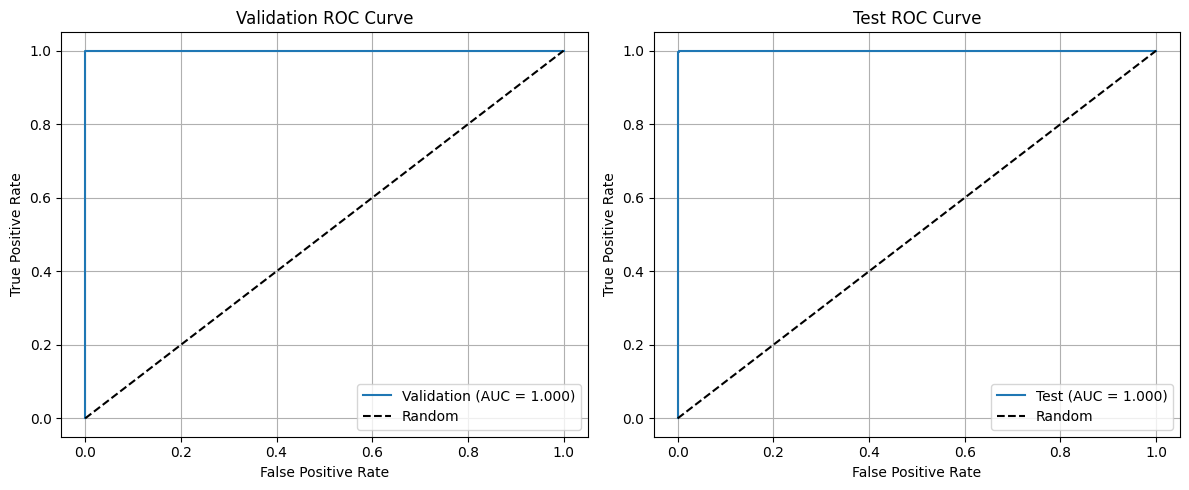

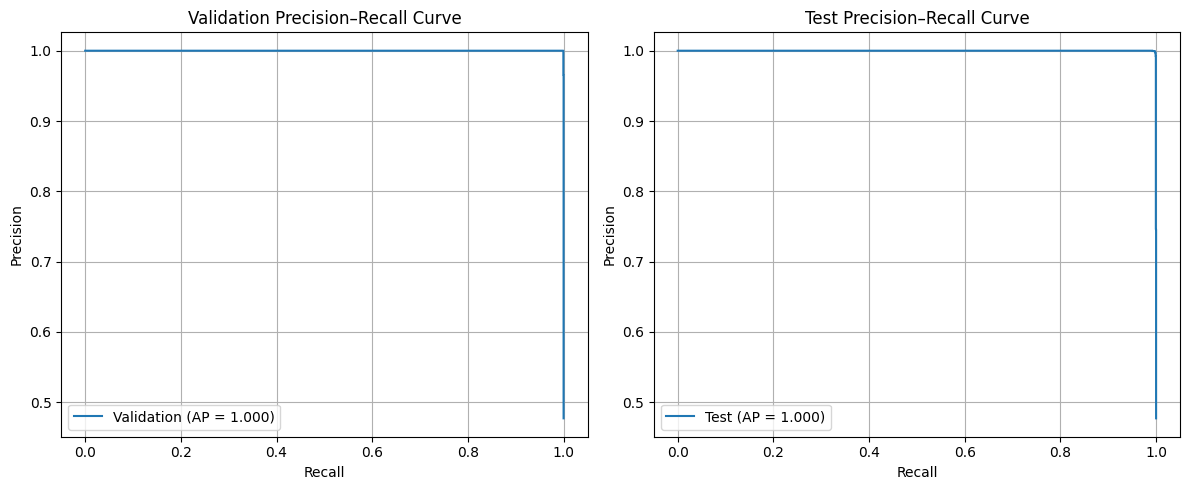

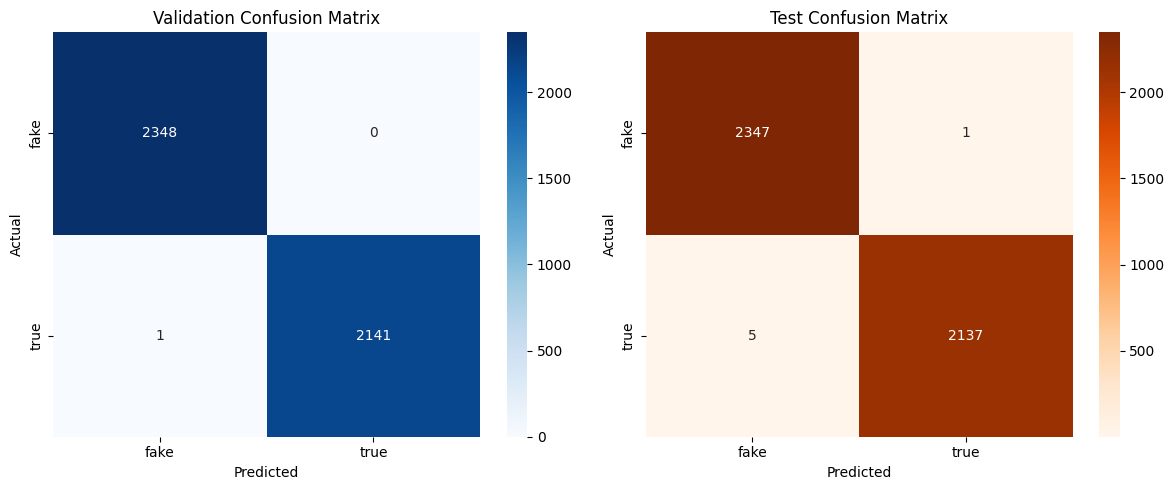

Initializing k-fold cross validation...
K-FOLD CROSS VALIDATION (k=5)


Convertng text to hierarchical format...: 100%|██████████| 40408/40408 [00:39<00:00, 1010.54it/s]



Fold 1/5
Model created with 10,141,802 parameters
Using device: cuda
Starting training...
Training samples:   32326
Validation samples: 8082


Epoch 1/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.50it/s, Loss=0.0005, Acc=1.0000]



Epoch 1/5:
  Train Loss: 0.0223, Train Acc: 0.9931
  Val   Loss: 0.0087, Val   Acc: 0.9984
  Learning Rate: 0.001000



Epoch 2/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.06it/s, Loss=0.0002, Acc=1.0000]



Epoch 2/5:
  Train Loss: 0.0061, Train Acc: 0.9989
  Val   Loss: 0.0075, Val   Acc: 0.9984
  Learning Rate: 0.001000
  No improvement. Patience: 1/2



Epoch 3/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.08it/s, Loss=0.0050, Acc=1.0000]



Epoch 3/5:
  Train Loss: 0.0039, Train Acc: 0.9989
  Val   Loss: 0.0071, Val   Acc: 0.9989
  Learning Rate: 0.000700



Epoch 4/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.11it/s, Loss=0.0002, Acc=1.0000]



Epoch 4/5:
  Train Loss: 0.0012, Train Acc: 0.9998
  Val   Loss: 0.0058, Val   Acc: 0.9993
  Learning Rate: 0.000700



Epoch 5/5: 100%|██████████| 2021/2021 [00:33<00:00, 59.90it/s, Loss=0.0000, Acc=1.0000]



Epoch 5/5:
  Train Loss: 0.0013, Train Acc: 0.9995
  Val   Loss: 0.0073, Val   Acc: 0.9990
  Learning Rate: 0.000700
  No improvement. Patience: 1/2

Training completed! Best validation accuracy: 0.9993


Getting predictions: 100%|██████████| 506/506 [00:02<00:00, 230.28it/s]


Computing standard classification metrics...
Fold 1 Results: Acc=0.9990, F1=0.9990

Fold 2/5
Model created with 10,141,802 parameters
Using device: cuda
Starting training...
Training samples:   32326
Validation samples: 8082


Epoch 1/5: 100%|██████████| 2021/2021 [00:34<00:00, 59.24it/s, Loss=0.0002, Acc=1.0000]



Epoch 1/5:
  Train Loss: 0.0237, Train Acc: 0.9926
  Val   Loss: 0.0129, Val   Acc: 0.9979
  Learning Rate: 0.001000



Epoch 2/5: 100%|██████████| 2021/2021 [00:36<00:00, 55.61it/s, Loss=0.0002, Acc=1.0000]



Epoch 2/5:
  Train Loss: 0.0075, Train Acc: 0.9983
  Val   Loss: 0.0119, Val   Acc: 0.9980
  Learning Rate: 0.001000



Epoch 3/5: 100%|██████████| 2021/2021 [00:33<00:00, 61.20it/s, Loss=0.0002, Acc=1.0000]



Epoch 3/5:
  Train Loss: 0.0046, Train Acc: 0.9990
  Val   Loss: 0.0102, Val   Acc: 0.9980
  Learning Rate: 0.000700
  No improvement. Patience: 1/2



Epoch 4/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.82it/s, Loss=0.0002, Acc=1.0000]



Epoch 4/5:
  Train Loss: 0.0028, Train Acc: 0.9994
  Val   Loss: 0.0093, Val   Acc: 0.9983
  Learning Rate: 0.000700



Epoch 5/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.00it/s, Loss=0.0000, Acc=1.0000]



Epoch 5/5:
  Train Loss: 0.0018, Train Acc: 0.9995
  Val   Loss: 0.0097, Val   Acc: 0.9983
  Learning Rate: 0.000700
  No improvement. Patience: 1/2

Training completed! Best validation accuracy: 0.9983


Getting predictions: 100%|██████████| 506/506 [00:02<00:00, 221.19it/s]


Computing standard classification metrics...
Fold 2 Results: Acc=0.9983, F1=0.9983

Fold 3/5
Model created with 10,141,802 parameters
Using device: cuda
Starting training...
Training samples:   32326
Validation samples: 8082


Epoch 1/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.30it/s, Loss=0.0006, Acc=1.0000]



Epoch 1/5:
  Train Loss: 0.0263, Train Acc: 0.9911
  Val   Loss: 0.0101, Val   Acc: 0.9977
  Learning Rate: 0.001000



Epoch 2/5: 100%|██████████| 2021/2021 [00:32<00:00, 61.82it/s, Loss=0.0015, Acc=1.0000]



Epoch 2/5:
  Train Loss: 0.0059, Train Acc: 0.9989
  Val   Loss: 0.0080, Val   Acc: 0.9984
  Learning Rate: 0.001000



Epoch 3/5: 100%|██████████| 2021/2021 [00:33<00:00, 61.23it/s, Loss=0.0001, Acc=1.0000]



Epoch 3/5:
  Train Loss: 0.0036, Train Acc: 0.9991
  Val   Loss: 0.0075, Val   Acc: 0.9989
  Learning Rate: 0.000700



Epoch 4/5: 100%|██████████| 2021/2021 [00:32<00:00, 61.43it/s, Loss=0.0021, Acc=1.0000]



Epoch 4/5:
  Train Loss: 0.0019, Train Acc: 0.9996
  Val   Loss: 0.0104, Val   Acc: 0.9985
  Learning Rate: 0.000700
  No improvement. Patience: 1/2



Epoch 5/5: 100%|██████████| 2021/2021 [00:31<00:00, 63.22it/s, Loss=0.0001, Acc=1.0000]



Epoch 5/5:
  Train Loss: 0.0015, Train Acc: 0.9995
  Val   Loss: 0.0054, Val   Acc: 0.9991
  Learning Rate: 0.000700

Training completed! Best validation accuracy: 0.9991


Getting predictions: 100%|██████████| 506/506 [00:02<00:00, 239.56it/s]


Computing standard classification metrics...
Fold 3 Results: Acc=0.9991, F1=0.9991

Fold 4/5
Model created with 10,141,802 parameters
Using device: cuda
Starting training...
Training samples:   32327
Validation samples: 8081


Epoch 1/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.41it/s, Loss=0.0002, Acc=1.0000]



Epoch 1/5:
  Train Loss: 0.0270, Train Acc: 0.9907
  Val   Loss: 0.0067, Val   Acc: 0.9985
  Learning Rate: 0.001000



Epoch 2/5: 100%|██████████| 2021/2021 [00:34<00:00, 59.06it/s, Loss=0.0002, Acc=1.0000]



Epoch 2/5:
  Train Loss: 0.0060, Train Acc: 0.9987
  Val   Loss: 0.0055, Val   Acc: 0.9988
  Learning Rate: 0.001000



Epoch 3/5: 100%|██████████| 2021/2021 [00:32<00:00, 62.03it/s, Loss=0.0005, Acc=1.0000]



Epoch 3/5:
  Train Loss: 0.0042, Train Acc: 0.9989
  Val   Loss: 0.0048, Val   Acc: 0.9991
  Learning Rate: 0.000700



Epoch 4/5: 100%|██████████| 2021/2021 [00:32<00:00, 61.80it/s, Loss=0.0000, Acc=1.0000]



Epoch 4/5:
  Train Loss: 0.0019, Train Acc: 0.9996
  Val   Loss: 0.0074, Val   Acc: 0.9989
  Learning Rate: 0.000700
  No improvement. Patience: 1/2



Epoch 5/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.79it/s, Loss=0.0000, Acc=1.0000]



Epoch 5/5:
  Train Loss: 0.0017, Train Acc: 0.9995
  Val   Loss: 0.0046, Val   Acc: 0.9990
  Learning Rate: 0.000700
  No improvement. Patience: 2/2
Early stopping triggered after 5 epochs
Training completed! Best validation accuracy: 0.9991


Getting predictions: 100%|██████████| 506/506 [00:02<00:00, 231.60it/s]


Computing standard classification metrics...
Fold 4 Results: Acc=0.9990, F1=0.9990

Fold 5/5
Model created with 10,141,802 parameters
Using device: cuda
Starting training...
Training samples:   32327
Validation samples: 8081


Epoch 1/5: 100%|██████████| 2021/2021 [00:32<00:00, 62.15it/s, Loss=0.0002, Acc=1.0000]



Epoch 1/5:
  Train Loss: 0.0367, Train Acc: 0.9864
  Val   Loss: 0.0054, Val   Acc: 0.9989
  Learning Rate: 0.001000



Epoch 2/5: 100%|██████████| 2021/2021 [00:33<00:00, 60.32it/s, Loss=0.0011, Acc=1.0000]



Epoch 2/5:
  Train Loss: 0.0074, Train Acc: 0.9984
  Val   Loss: 0.0051, Val   Acc: 0.9989
  Learning Rate: 0.001000
  No improvement. Patience: 1/2



Epoch 3/5: 100%|██████████| 2021/2021 [00:33<00:00, 59.65it/s, Loss=0.0000, Acc=1.0000]



Epoch 3/5:
  Train Loss: 0.0046, Train Acc: 0.9988
  Val   Loss: 0.0029, Val   Acc: 0.9991
  Learning Rate: 0.000700



Epoch 4/5: 100%|██████████| 2021/2021 [00:33<00:00, 59.71it/s, Loss=0.0005, Acc=1.0000]



Epoch 4/5:
  Train Loss: 0.0024, Train Acc: 0.9994
  Val   Loss: 0.0020, Val   Acc: 0.9995
  Learning Rate: 0.000700



Epoch 5/5: 100%|██████████| 2021/2021 [00:34<00:00, 59.22it/s, Loss=0.0000, Acc=1.0000]



Epoch 5/5:
  Train Loss: 0.0019, Train Acc: 0.9996
  Val   Loss: 0.0030, Val   Acc: 0.9994
  Learning Rate: 0.000700
  No improvement. Patience: 1/2

Training completed! Best validation accuracy: 0.9995


Getting predictions: 100%|██████████| 506/506 [00:02<00:00, 229.43it/s]


Computing standard classification metrics...
Fold 5 Results: Acc=0.9994, F1=0.9994
Computing cross-validation statistics...

CROSS-VALIDATION SUMMARY
Accuracy: 0.9990 ± 0.0004
Precision: 0.9990 ± 0.0004
Recall: 0.9990 ± 0.0004
F1_score: 0.9990 ± 0.0004


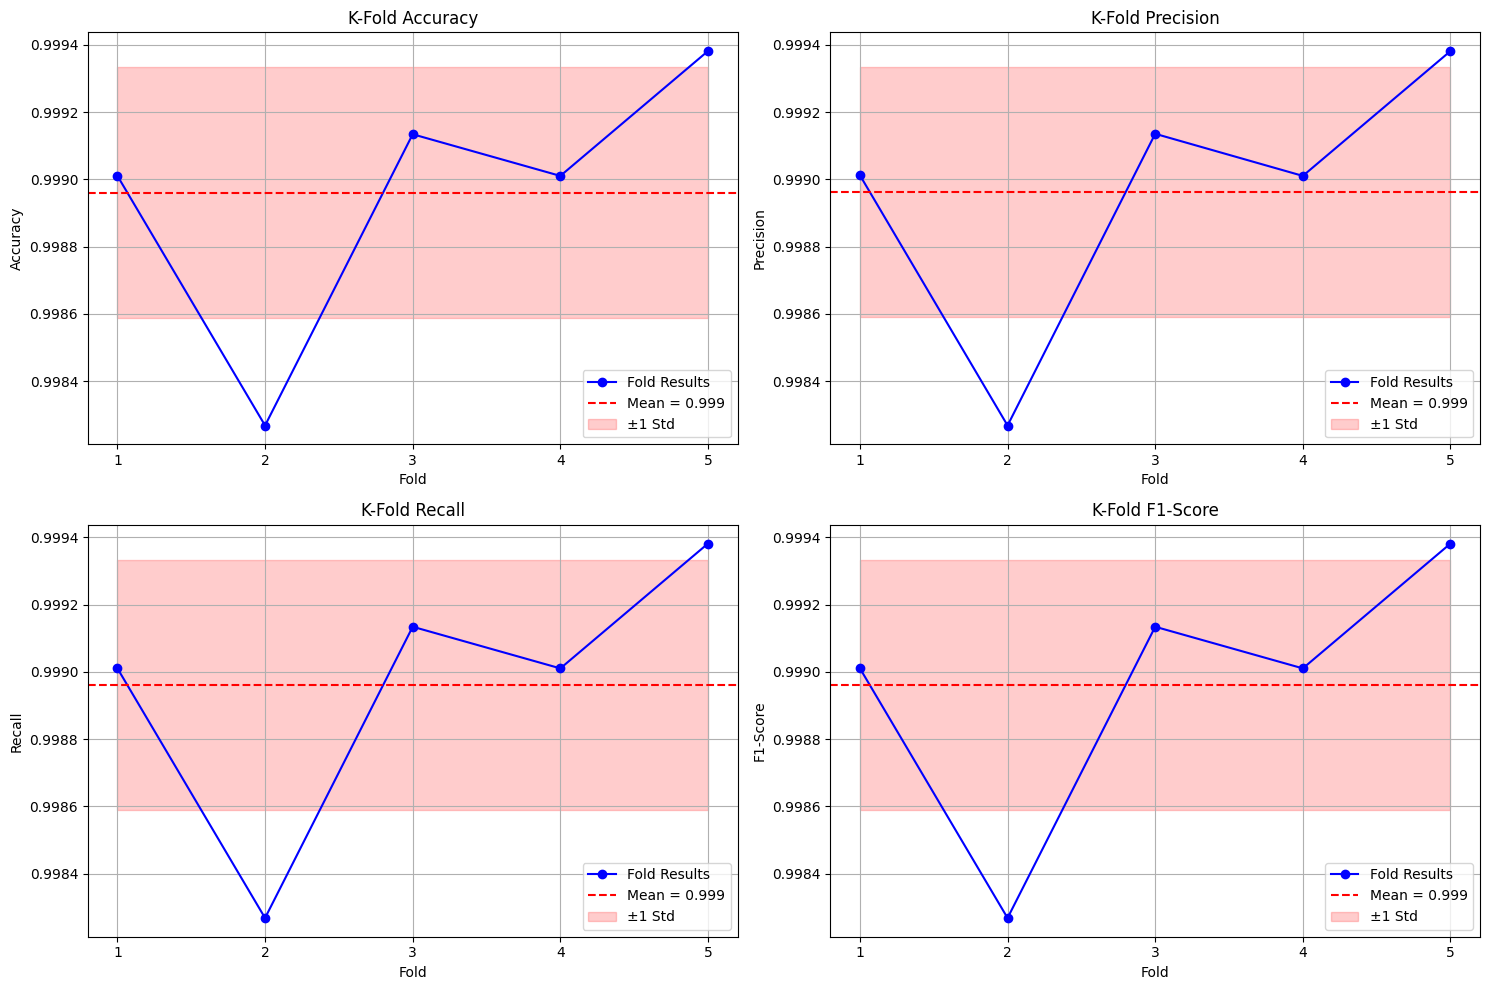

Performing bootstrap validation...
BOOTSTRAP VALIDATION (n=100)


Getting predictions: 100%|██████████| 281/281 [00:01<00:00, 236.02it/s]


Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classification metrics...
 Bootstrap iteration 20/100
Computing standard classification metrics...
Computing standard classification metrics...
Computing standard classifi

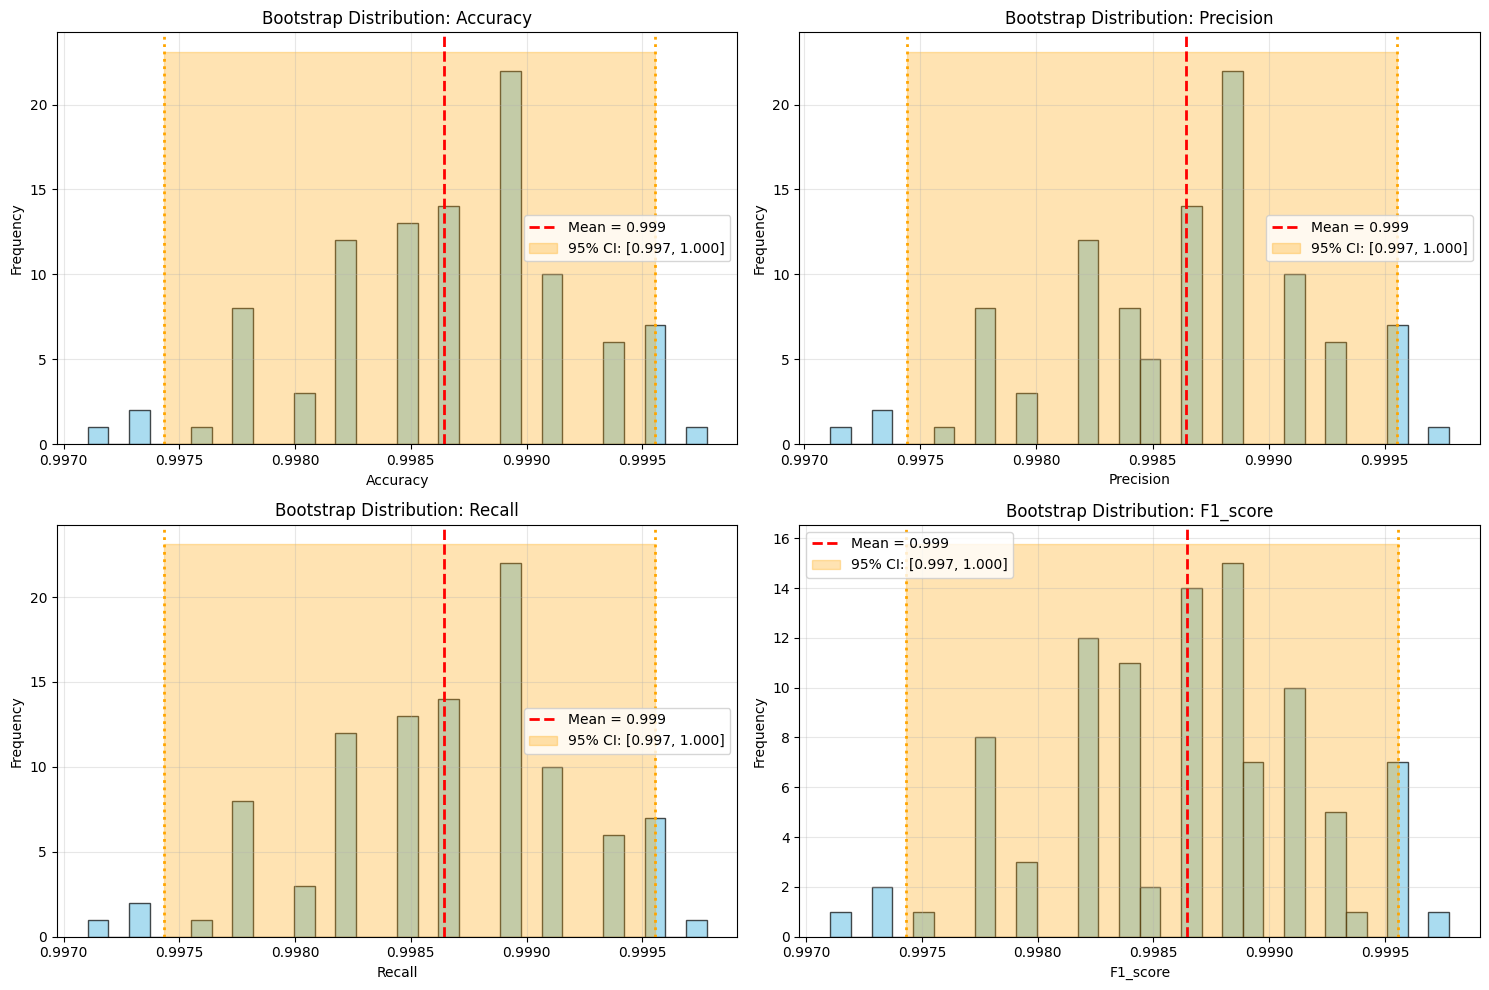


RESULTS

{'validation_report': {'validation_metrics': {'accuracy': 0.9997772828507795, 'precision': 0.9997773776643807, 'recall': 0.9997772828507795, 'f1_score': 0.9997772805590923}, 'test_metrics': {'accuracy': 0.9986636971046771, 'precision': 0.9986651742748265, 'recall': 0.9986636971046771, 'f1_score': 0.9986636413036017}, 'val_auc': np.float64(0.999984888901614), 'test_auc': np.float64(0.9998463042229953), 'overfitting_gap': 0.00111358574610243}, 'kfold_results': ([{'fold': 1, 'accuracy': 0.9990101460034645, 'precision': 0.9990120158575312, 'recall': 0.9990101460034645, 'f1_score': 0.9990100998325805}, {'fold': 2, 'accuracy': 0.9982677555060628, 'precision': 0.9982681656979159, 'recall': 0.9982677555060628, 'f1_score': 0.9982677155336521}, {'fold': 3, 'accuracy': 0.9991338777530314, 'precision': 0.9991353096981729, 'recall': 0.9991338777530314, 'f1_score': 0.9991338424968841}, {'fold': 4, 'accuracy': 0.9990100235119416, 'precision': 0.9990101685724628, 'recall': 0.9990100235119416

In [7]:
# Initialize analyzer
analyzer = FakeNewsAnalyzer()

# Run complete analysis
results = analyzer.run_complete_analysis()

print("\nRESULTS\n")
print(results)